<a href="https://colab.research.google.com/github/trchudley/GEOG2462/blob/main/Week_4_Climate_Data/1_Download_Climate_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and visualise ERA-5 climate data

# Import GEE and relevant tools

In [2]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

ee.Authenticate()  # Trigger the authentication flow.
ee.Initialize(project='ee-trchudley')    # Change to your own default project name.

## ERA-5 data

In [9]:
dataset = ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR').first();

visualization = {
  'bands': ['temperature_2m'], 'min': 250, 'max': 320,
  'palette': [
    '000080', '0000d9', '4000ff', '8000ff', '0080ff', '00ffff',
    '00ff80', '80ff00', 'daff00', 'ffff00', 'fff500', 'ffda00',
    'ffb000', 'ffa400', 'ff4f00', 'ff2500', 'ff0a00', 'ff00ff',
  ]
};

Map = geemap.Map()  # Create empty map
Map.setCenter(70, 45, 3);
Map.addLayer(
    dataset, visualization, 'Air temperature [K] at 2m height', True, 0.8
    )
Map

Map(center=[45, 70], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

−273.15 °C

## Download ERA-5 time series

In [11]:
# Define download parameters
latitude = 50.614           # Degrees of latitude
longitude = -3.984          # Degrees of longitude
location_name = 'dartmoor'  # recognisable name, to create a useful file name

# Create a point geometry at the specified location
point = ee.Geometry.Point(longitude, latitude)


Relevant bands can be found here https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_MONTHLY_AGGR#bands

In [35]:
# Define the dataset as the ERA5 monthly mean data
dataset = ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')

# Filter the dataset to the desired time range
dataset = dataset.filter(ee.Filter.date('2013-01-01', '2023-12-31'))

# Select only the relevant variables
dataset = dataset.select([
    'temperature_2m',
    'total_precipitation_sum',
    ])


# Go through the collection, finding the nearest values to the set lat/lon
mapped = dataset.map(
    lambda image: image.set(
        'era5',
        image.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=point,
            scale=image.projection().nominalScale()  # Use native resolution
        ).set('year', image.date().get('year')).set('month', image.date().get('month'))
    )
)

# Get this data as a dictionary, and turn it into a Pandas dataframe (table)
era5_dict = mapped.aggregate_array('era5').getInfo()
era5 = pd.DataFrame(era5_dict)

# Transition temperature from Kelvin to Celcius
era5['temperature_2m'] = era5['temperature_2m'] - 274.15

# Transition total rainfall from m to mm
era5['total_precipitation_sum'] = era5['total_precipitation_sum'] * 1000


# Construct a proper 'date' column from the year and month data.
dates = pd.to_datetime(dict(year=era5.year, month=era5.month, day=15))
era5.drop(labels=['year', 'month'], axis=1,inplace = True)
era5.insert(0, 'date', dates)


In [36]:

era5

,date,temperature_2m,total_precipitation_sum
0,2013-01-15,3.264098,114.420594
1,2013-02-15,1.930110,50.615094
2,2013-03-15,1.430070,93.341122
3,2013-04-15,4.727196,45.565150
4,2013-05-15,7.400893,82.754449
...,...,...,...
127,2023-08-15,14.069893,72.566802
128,2023-09-15,14.588207,81.861163
129,2023-10-15,11.033184,121.479082
130,2023-11-15,6.661906,131.844635


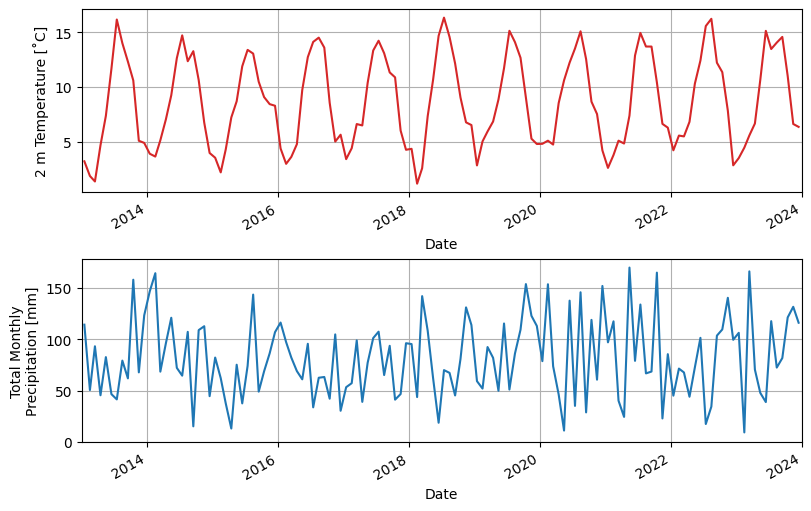

In [60]:
fig, axes = plt.subplots(nrows=2, layout='constrained', figsize=(8, 5))

# For the first axis...
ax = axes[0]

# Plot the temperature in red on the first axis
era5.plot('date', 'temperature_2m', ax=ax, color='tab:red', legend=False)

# Set the y axis label
ax.set_ylabel('2 m Temperature [˚C]')

# For the second axis...
ax = axes[1]

# Plot the total monthly precipitaiton in blue on the second axis
era5.plot('date', 'total_precipitation_sum', ax=ax, color='tab:blue', legend=False)

# Set the y axis label ('\n' forces a line break to fit it on the axis)
ax.set_ylabel('Total Monthly\nPrecipitation [mm]')

# Set the y lower limit to zero
ax.set_ylim(0, None)

for ax in axes:  # Loop through both axes, applying the same rules to both

  # Apply a grid
  ax.grid()

  # Set the x axis limits between 2013 and 2024
  ax.set_xlim(pd.to_datetime('2013-01-01'), pd.to_datetime('2024-01-01'))

  # Set the x axis label to 'Date'
  ax.set_xlabel('Date')


## Export data to Google Drive

In [63]:
drive.mount('/content/drive')

Mounted at /content/drive


In [64]:
# You can edit this variable
folder = 'scires_project_2C'


In [67]:
# Construct the filename automatically
filename = location_name + '_era5.csv'

# Print out filename for reference
print("The image will be saved to your Google Drive at:\n" + folder + '/' + filename + '\n')

# Export the pandas dataframe to a csv file
era5.to_csv(f'/content/drive/My Drive/{folder}/{filename}', index=False)

print('Saved.')

The image will be saved to your Google Drive at:
scires_project_2C/dartmoor_era5.csv

Saved.
